In [9]:
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

True

In [10]:
import scanpy as sc

In [4]:
sc.settings.verbosity = 3  
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-06-09 00:04:19.332272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 00:04:20.766225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [4]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [5]:
import scvi

In [6]:
adata_2 = sc.read_10x_h5(
    "/home/mmigl/cellbender/output/sample2_filtered_filtered.h5"
)

In [7]:
adata_2

AnnData object with n_obs × n_vars = 3687 × 37143
    var: 'gene_ids', 'feature_types', 'genome'

In [161]:
#Pre-processing for improving the quality of the data before analysis

In [8]:
adata_2.var_names_make_unique()
sc.pp.filter_cells(adata_2, min_genes=200) 
sc.pp.filter_genes(adata_2, min_cells=3) 

In [9]:
adata_2

AnnData object with n_obs × n_vars = 2960 × 16317
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [190]:
#Doublet Removal

In [23]:
#pip install --user scikit-misc

In [10]:
doublet_2 = adata_2.copy()

In [11]:
sc.pp.highly_variable_genes(doublet_2, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [12]:
scvi.model.SCVI.setup_anndata(doublet_2)
vae = scvi.model.SCVI(doublet_2)
vae.train()

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:12<00:00,  5.54it/s, v_num=1, train_loss_step=493, train_loss_epoch=522]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:12<00:00,  5.49it/s, v_num=1, train_loss_step=493, train_loss_epoch=522]


In [13]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 215/400:  54%|████████▌       | 215/400 [00:39<00:34,  5.38it/s, v_num=1, train_loss_step=0.615, train_loss_epoch=0.415]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.405. Signaling Trainer to stop.


In [14]:
doublet = solo.predict()
doublet['prediction'] = solo.predict(soft = False)

In [15]:
doublet.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        1176     1176
singlet        1784     1784

In [16]:
doublet['difference'] = doublet.doublet - doublet.singlet

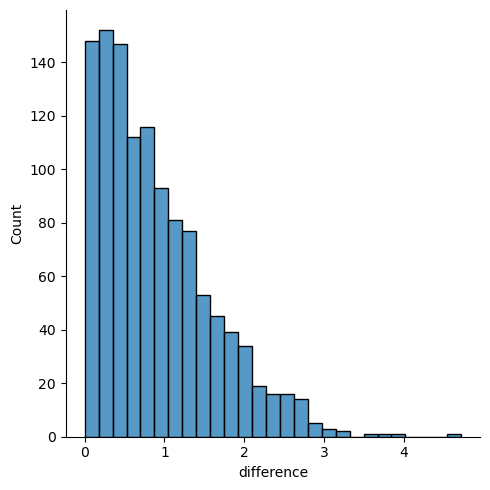

In [17]:
import seaborn as sns
sns.displot(doublet[doublet.prediction == 'doublet'], x = 'difference')

In [18]:
doublet = doublet[(doublet['prediction'] == 'doublet') & (doublet['difference'] > 1)]

In [19]:
adata_2.obs['doublet'] = adata_2.obs.index.isin(doublet.index)

In [21]:
adata_2 = adata_2[~adata_2.obs.doublet]

In [23]:
adata_2

View of AnnData object with n_obs × n_vars = 2528 × 16317
    obs: 'n_genes', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [24]:
adata_2.var["mt"] = adata_2.var_names.str.startswith("MT-")

In [25]:
sc.pp.calculate_qc_metrics(adata_2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

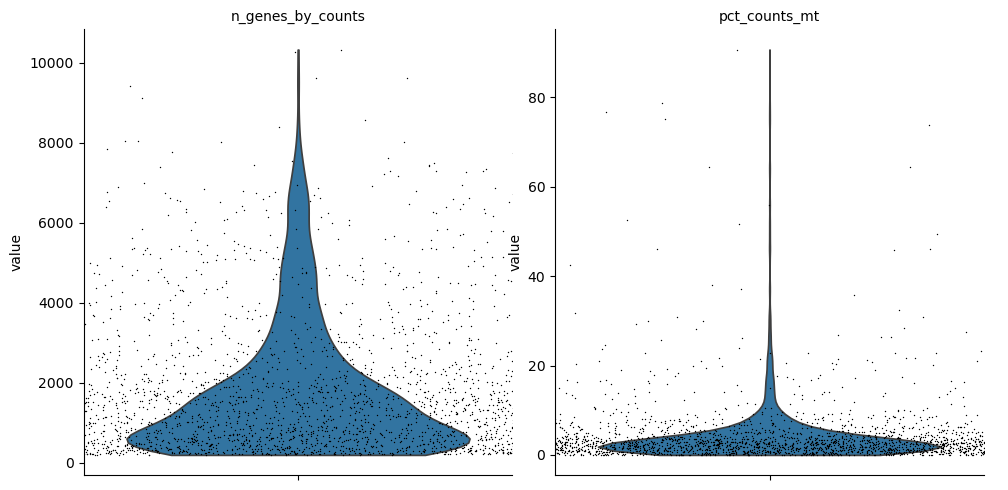

In [26]:
sc.pl.violin(adata_2, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

In [27]:
import numpy as np

In [28]:
def pp(adata):
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.write('adata_2_filtered_new.h5ad', adata)
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.normalize_total(adata) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata 
    adata = adata[:, adata.var.highly_variable] 
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 
    sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.write('adata_2_pca_new.h5ad', adata)
    return adata

In [29]:
adata_2 = pp(adata_2)

In [15]:
adata_2 = sc.read('adata_2_pca_new.h5ad')

In [16]:
adata_2

AnnData object with n_obs × n_vars = 2413 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Counts'

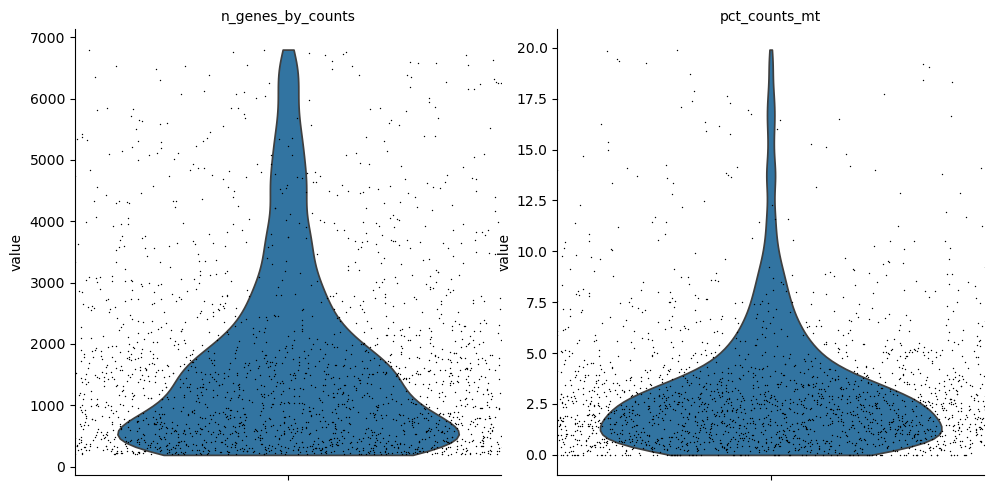

In [17]:
sc.pl.violin(adata_2, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

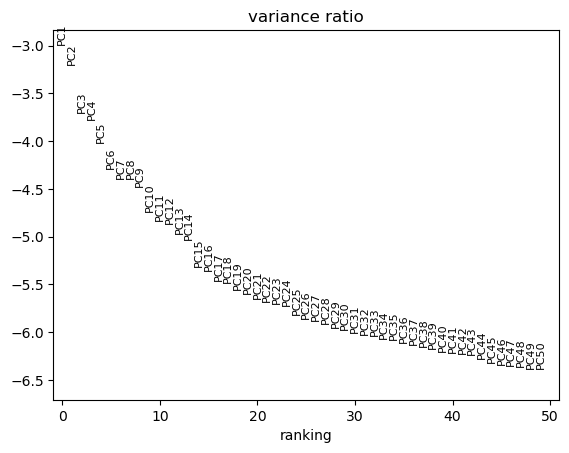

In [18]:
sc.pl.pca_variance_ratio(adata_2, log=True, n_pcs=50)

In [19]:
sc.pp.neighbors(adata_2, n_pcs=40)
sc.tl.umap(adata_2)
sc.tl.leiden(adata_2, resolution = 0.5)
sc.tl.rank_genes_groups(adata_2, "leiden", method="wilcoxon")
#sc.write('adata_2_de_new.h5ad', adata_2)

2024-06-09 10:26:25.901106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 10:26:27.376114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_15237/3060621665.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_2, resolution = 0.5)


In [20]:
adata_2

AnnData object with n_obs × n_vars = 2413 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Counts'
    obsp: 'distances', 'connectivities'

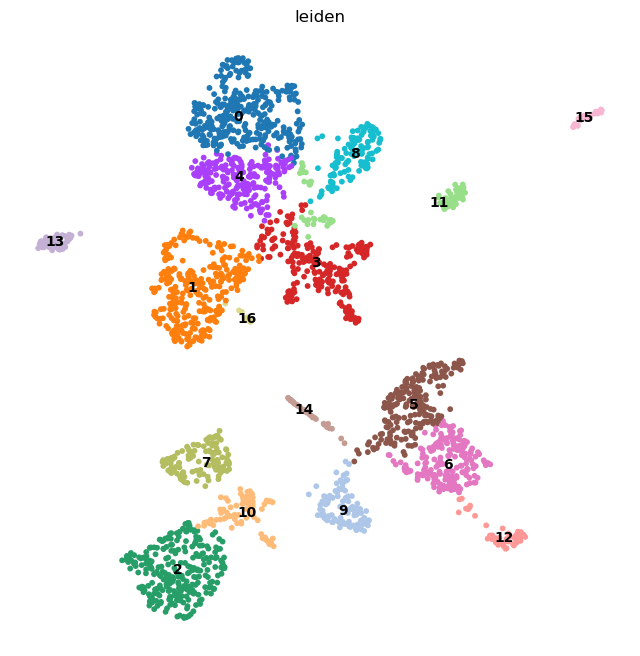

In [21]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_2, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [22]:
n_markers = ['S100A12', 'SPP1', 'VEGFA', 'CXCL8', 'IL1B', 'CXCR2', 'IFIT1', 'ISG15', 'MMP9']

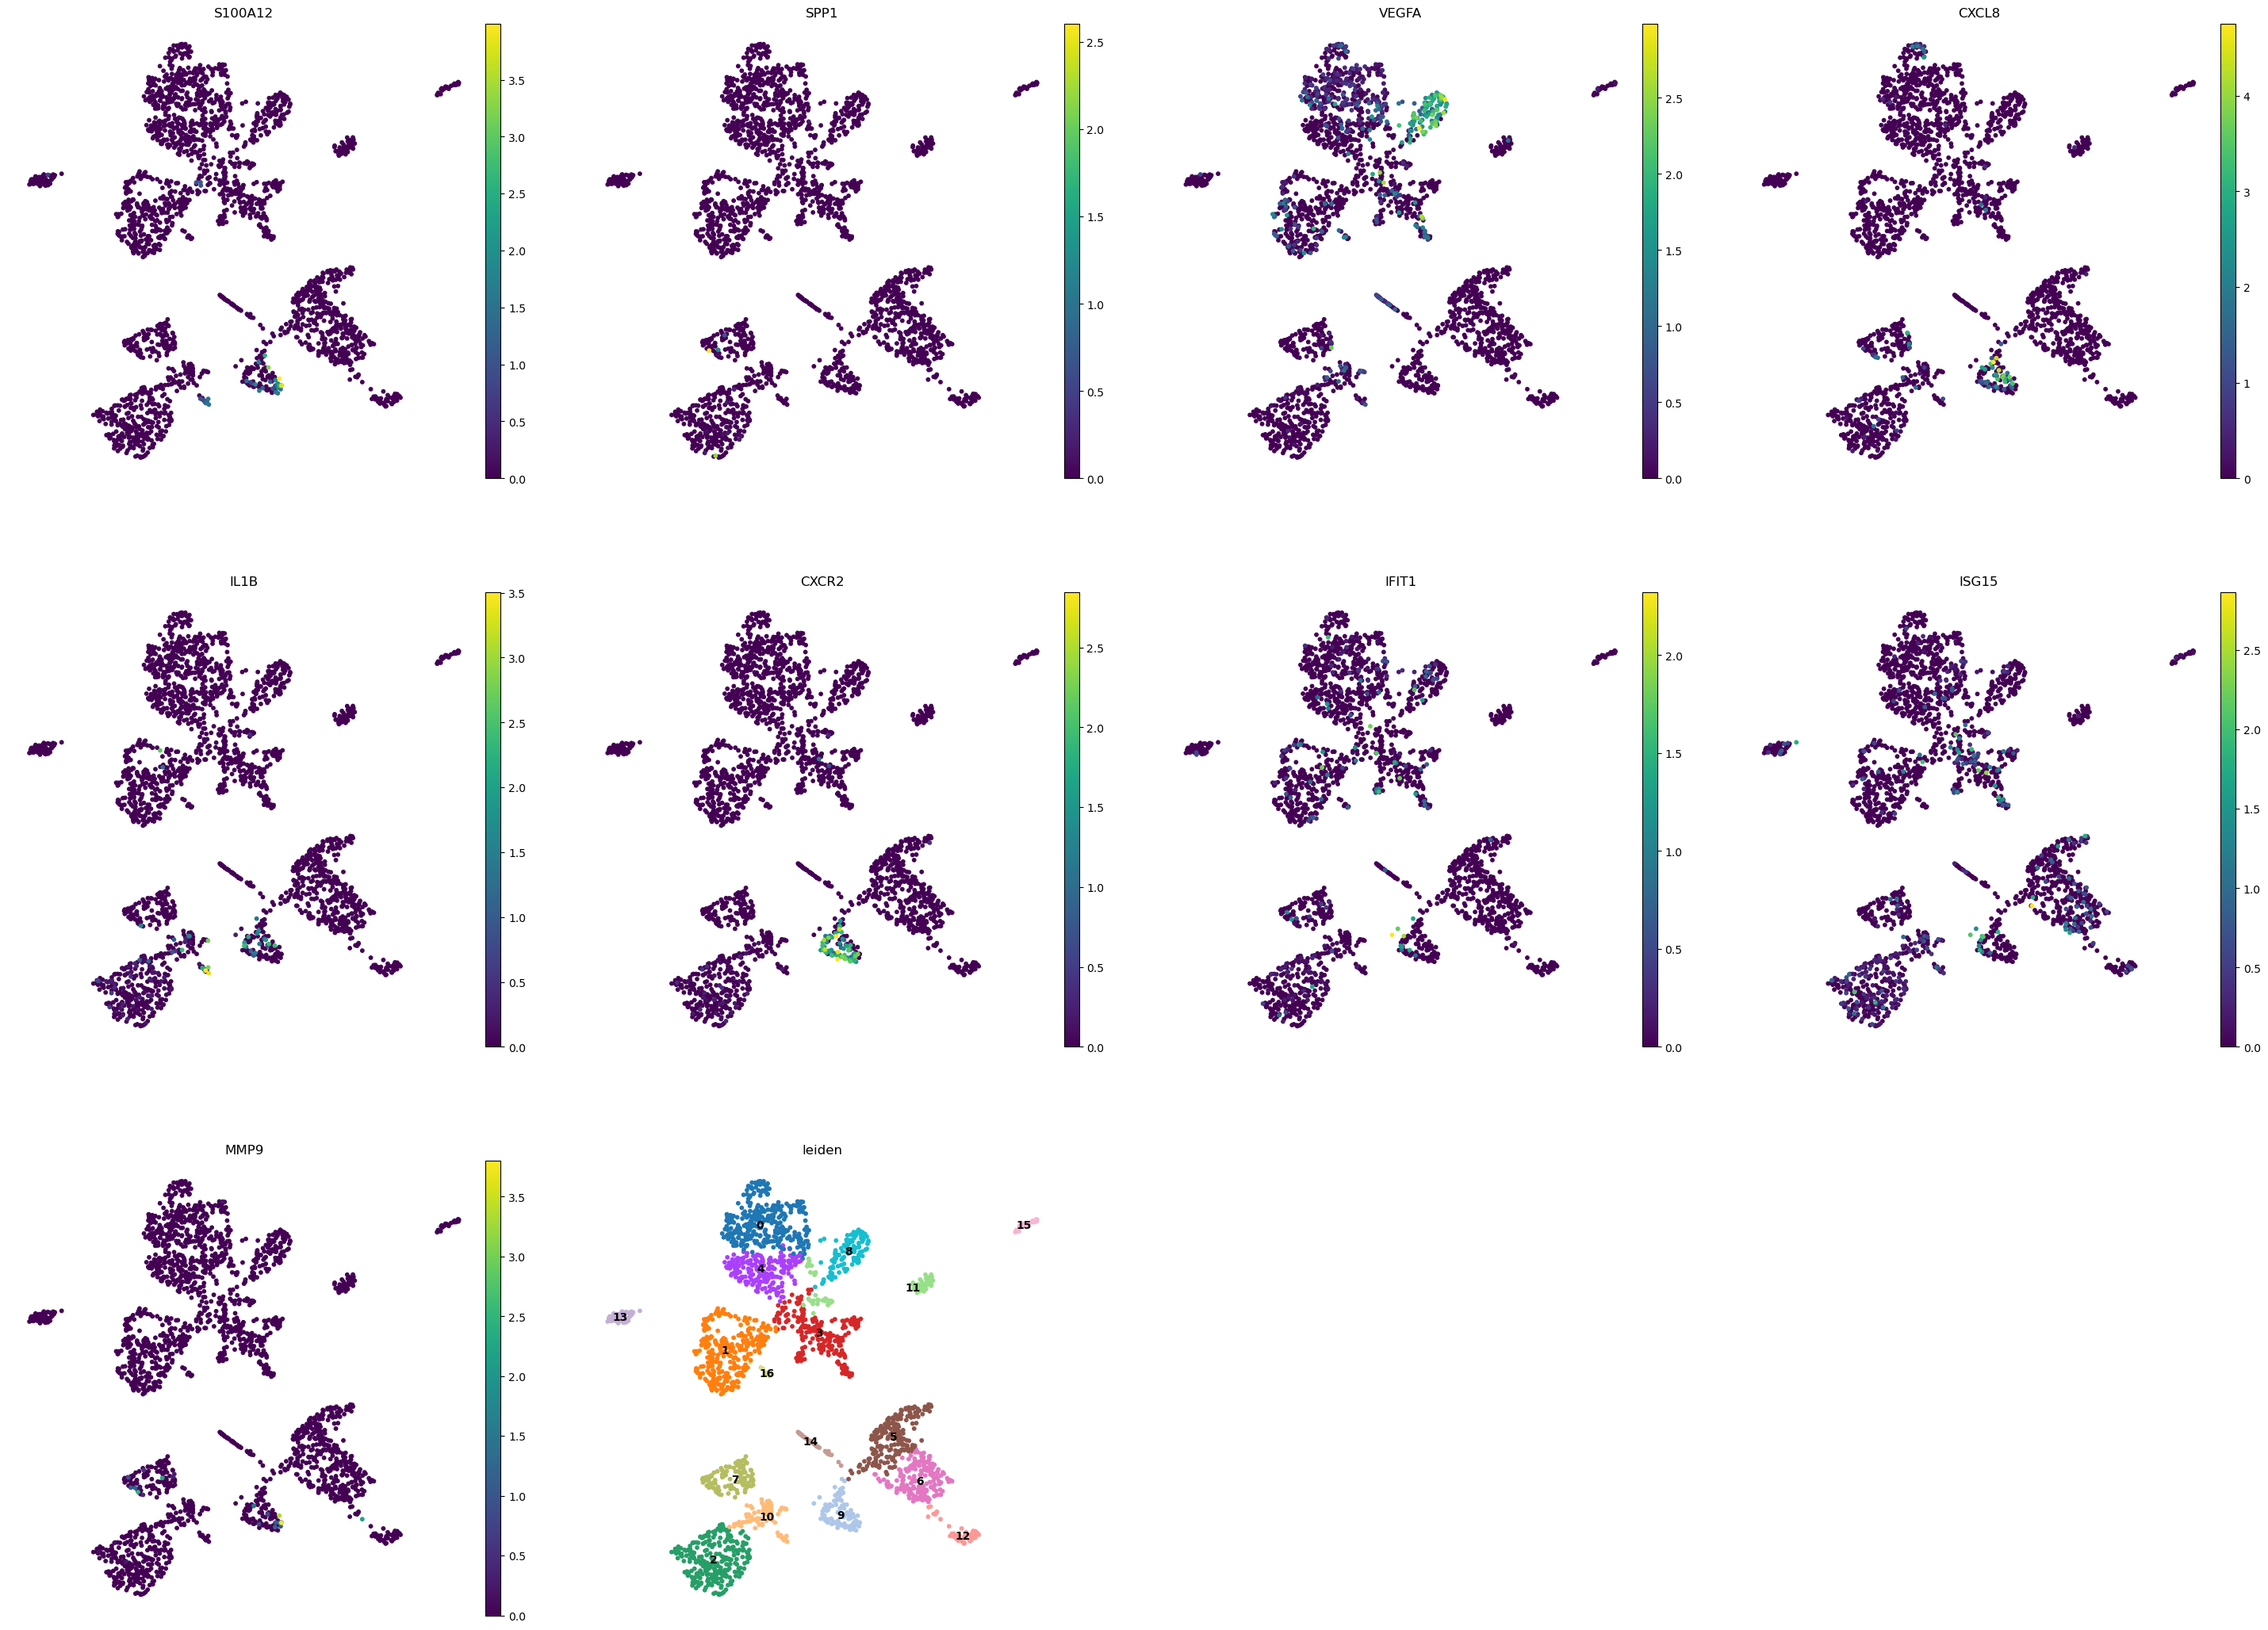

In [23]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_2, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [24]:
markers = {}
for c in adata_2.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_2, group=c)
    markers[c] = df['names'].tolist()[:5]

In [25]:
markers

{'0': ['ACOXL', 'SLC22A31', 'CAPN8', 'NTN4', 'ROS1'],
 '1': ['DCN', 'PTGDS', 'FBLN1', 'COL1A2', 'LUM'],
 '2': ['FBP1', 'FABP4', 'MARCO', 'MSR1', 'OLR1'],
 '3': ['AQP1', 'CDH5', 'VWF', 'EGFL7', 'LIMS2'],
 '4': ['RNASE1', 'CXCL17', 'C4BPA', 'PGC', 'SFTA2'],
 '5': ['TRAC', 'TRBC2', 'CD2', 'IL7R', 'SPOCK2'],
 '6': ['CCL5', 'KLRK1', 'TRAC', 'CD8A', 'CD2'],
 '7': ['LGMN', 'C1QC', 'MS4A6A', 'C1QB', 'CD14'],
 '8': ['AGER', 'EMP2', 'CAV1', 'GPRC5A', 'CYP4B1'],
 '9': ['S100A9', 'S100A8', 'RGS2', 'MNDA', 'FPR1'],
 '10': ['FGL2', 'CSF2RA', 'MS4A6A', 'MPEG1', 'CLEC7A'],
 '11': ['ACTA2', 'COL6A2', 'TAGLN', 'COL4A2', 'TPM1'],
 '12': ['CD79A', 'MS4A1', 'IRF8', 'CD79B', 'LTB'],
 '13': ['CCL21', 'FLT4', 'IGFBP7', 'PROX1', 'MMRN1'],
 '14': ['CPA3', 'TPSAB1', 'TPSB2', 'GATA2', 'MS4A2'],
 '15': ['TXNDC5', 'MZB1', 'JCHAIN', 'DERL3', 'PIM2'],
 '16': ['KCNMA1', 'LEPR', 'CLU', 'SFRP2', 'IGFBP5']}

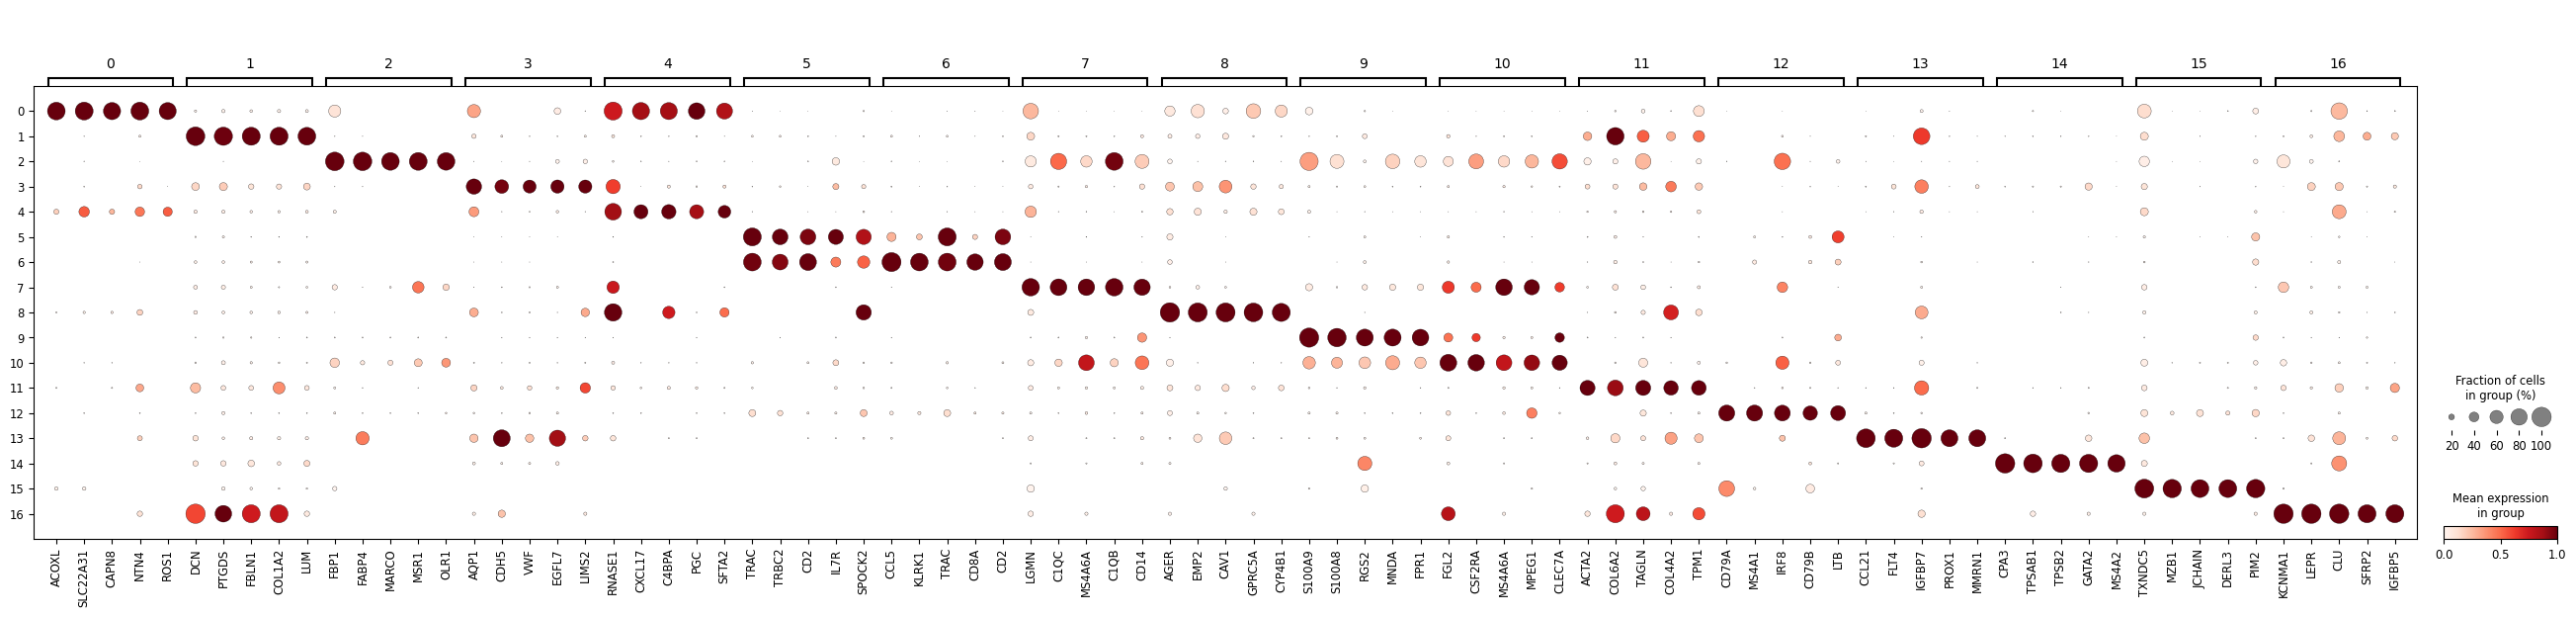

In [26]:
sc.pl.dotplot(adata_2, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [51]:
subset_adata_2 = adata_2[adata_2.obs['leiden'].isin(['9','10','8']), :]

In [27]:
sc.pp.neighbors(subset_adata_2, n_pcs=40)
sc.tl.leiden(subset_adata_2, resolution = 0.5)
sc.pl.umap(subset_adata_2, color = 'leiden', s = 70, frame
sc.tl.umap(subset_adata_2)
sc.write('subset_adata_2.h5ad', subset_adata_2)

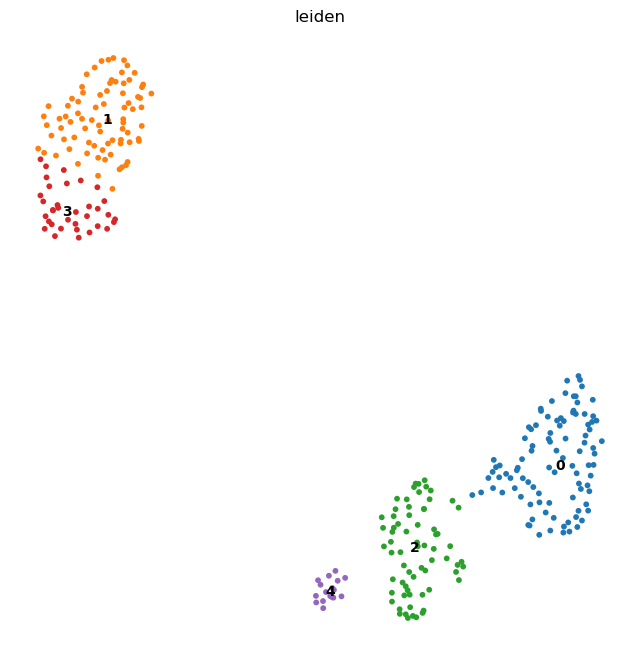

In [28]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_2, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

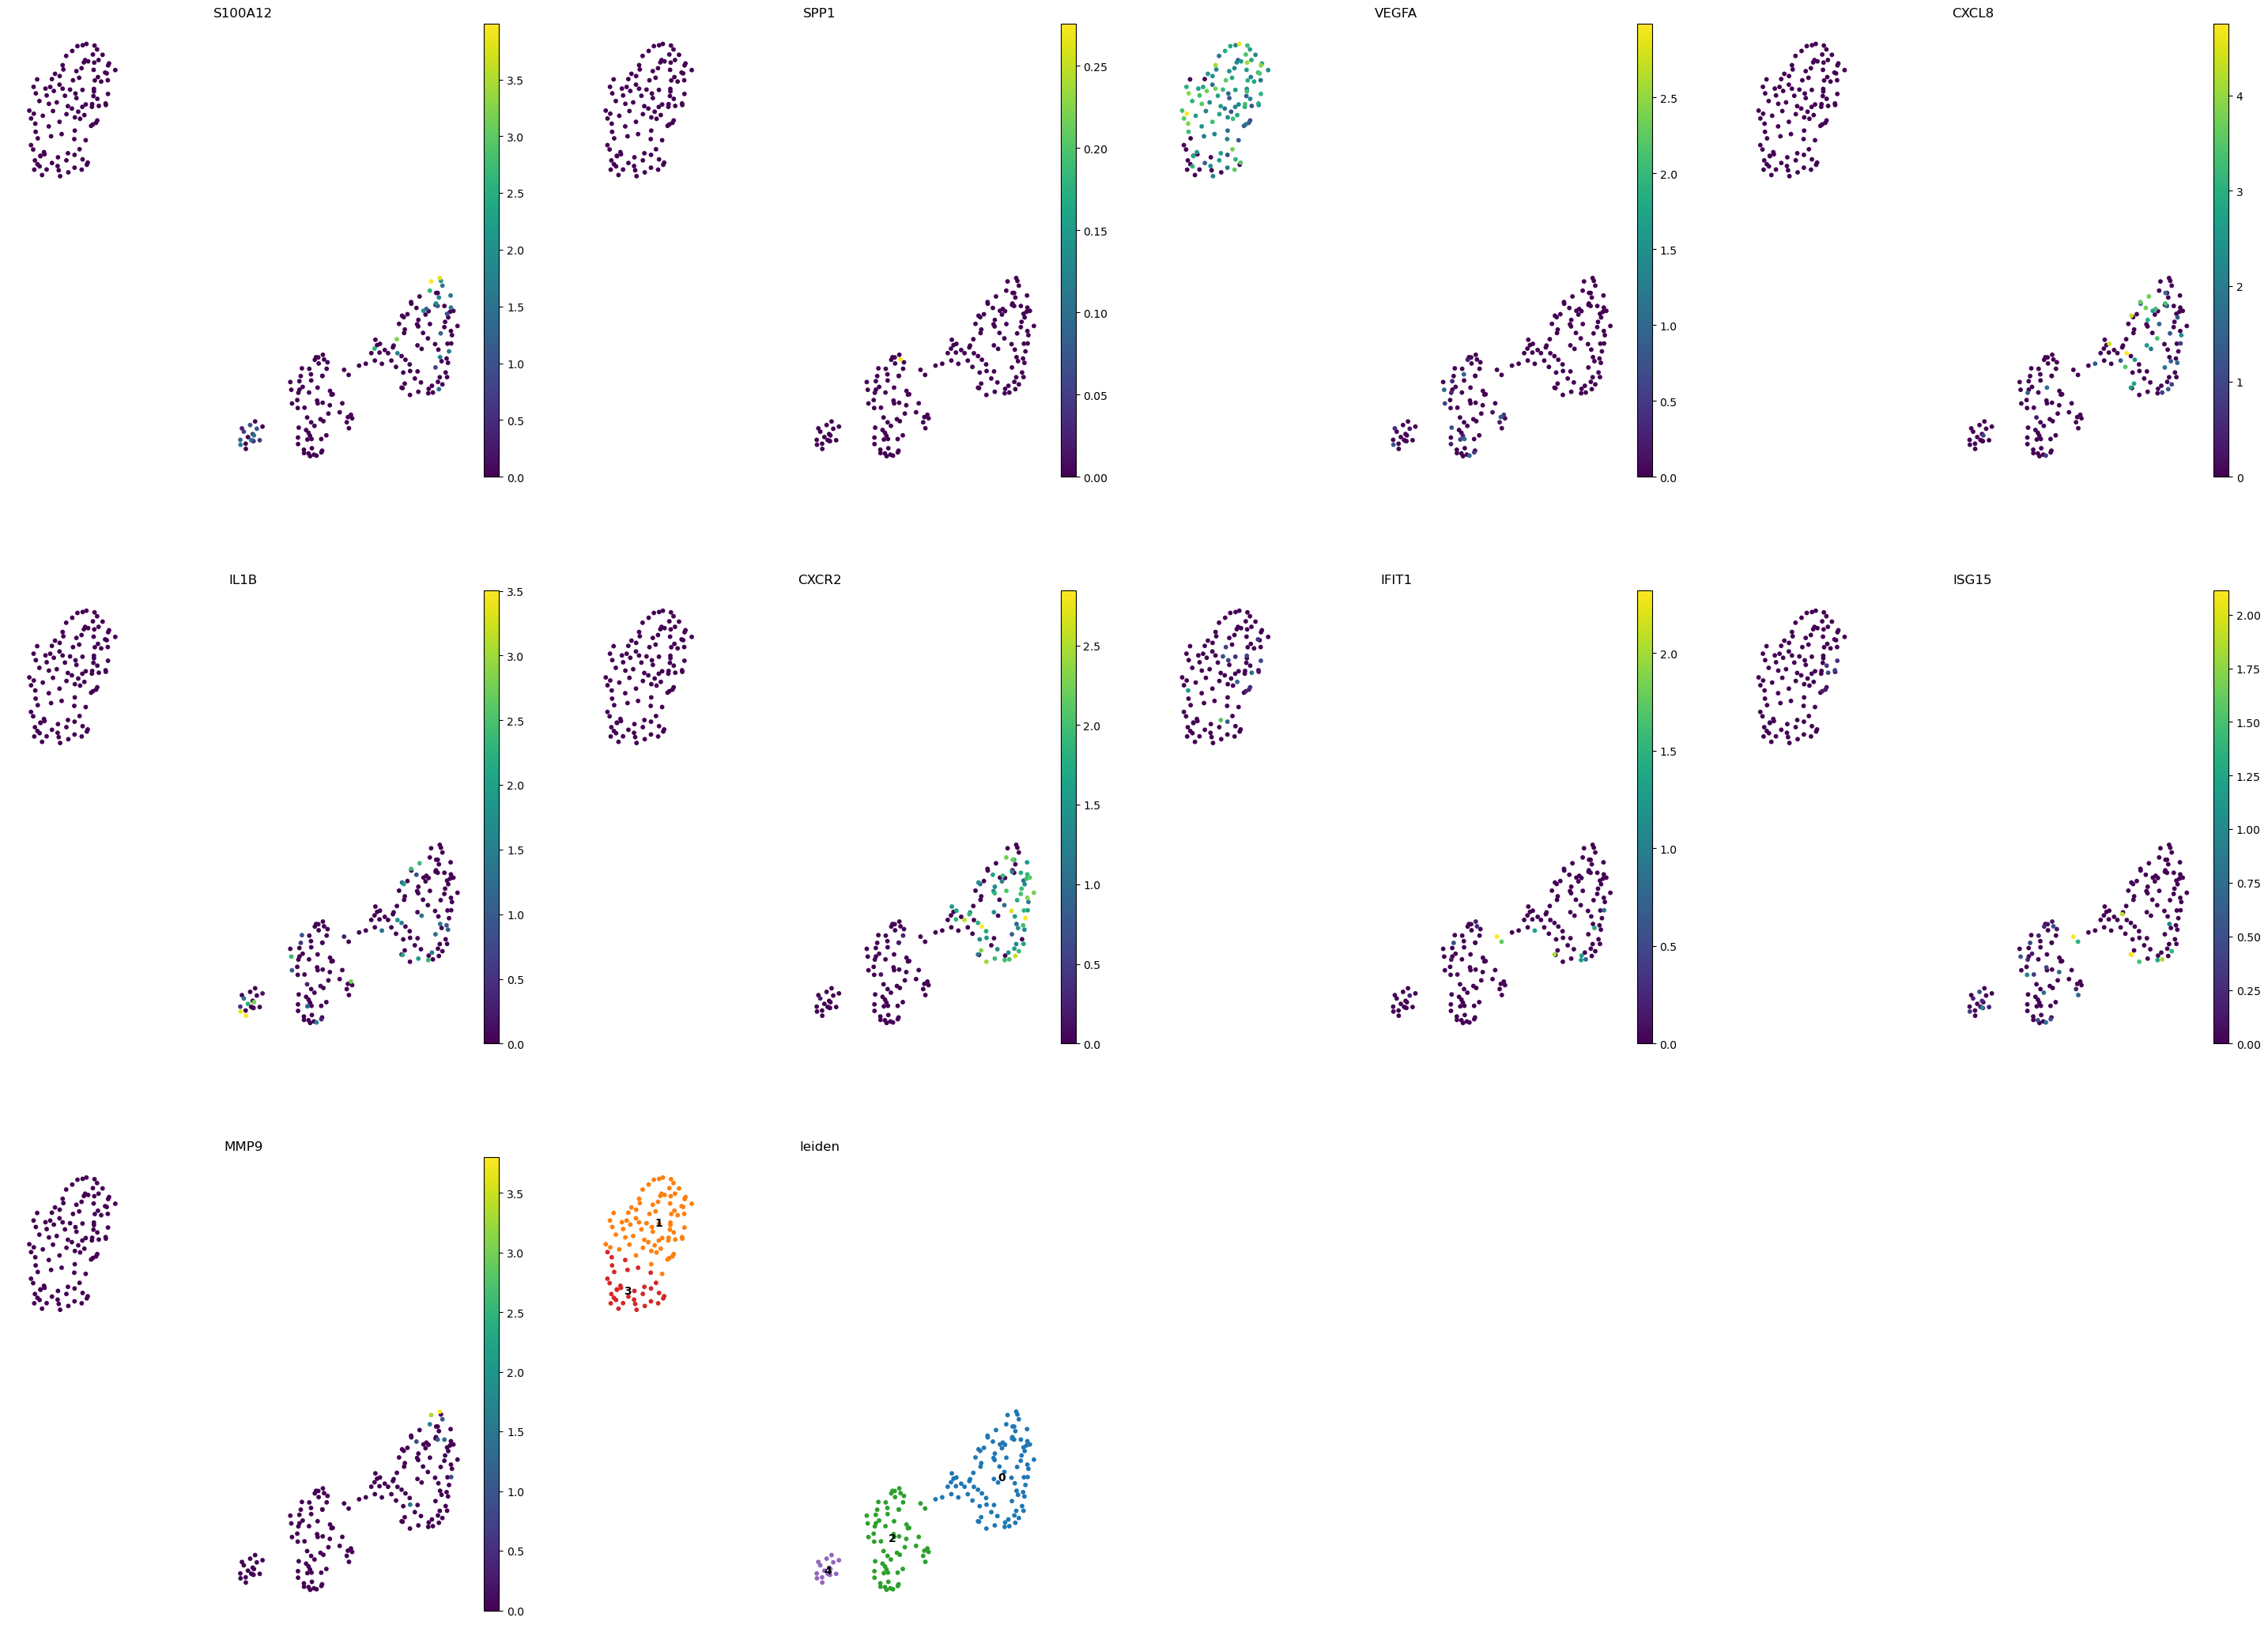

In [29]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_2, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [ ]:
#SCVI for clustering

In [30]:
import scvi
def model(adata):
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable] 
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(adata, layer = "Counts", continuous_covariate_keys=['pct_counts_mt', 'total_counts'])
    vae = scvi.model.SCVI(adata)
    vae.train()
    vae.save(model_path)
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    adata.layers["X_normalized_scVI"] = vae.get_normalized_expression()
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution = 0.5)
    sc.write('adata_2_scvi_new.h5ad', adata)
    return adata

In [31]:
scvi_adata_2 = sc.read('adata_2_filtered_new.h5ad')

In [32]:
model_path = 'vae_model_2/'

In [34]:
scvi_adata_2 = model(scvi_adata_2)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:02<00:00,  6.45it/s, v_num=1, train_loss_step=552, train_loss_epoch=513]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:02<00:00,  6.39it/s, v_num=1, train_loss_step=552, train_loss_epoch=513]


In [35]:
vae = scvi.model.SCVI.load(model_path, adata=scvi_adata_2)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File vae_model_2/model.pt already downloaded                                                              


In [36]:
scvi_adata_2

AnnData object with n_obs × n_vars = 2413 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'distances', 'connectivities'

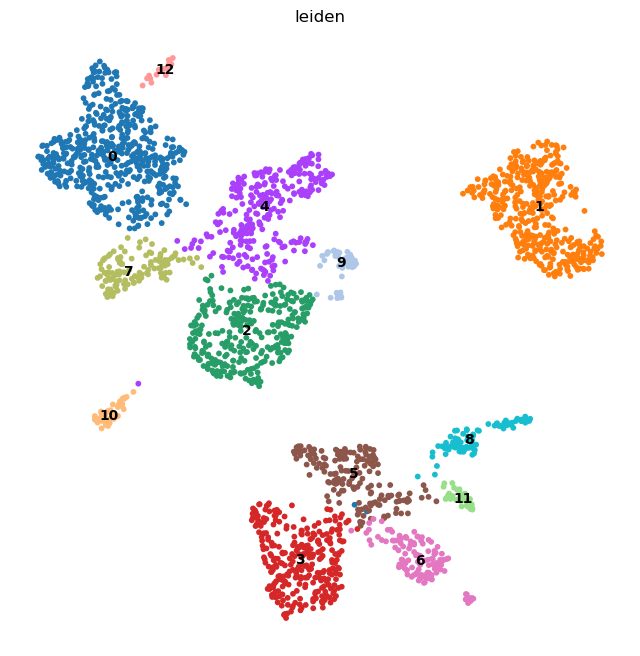

In [37]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_2, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

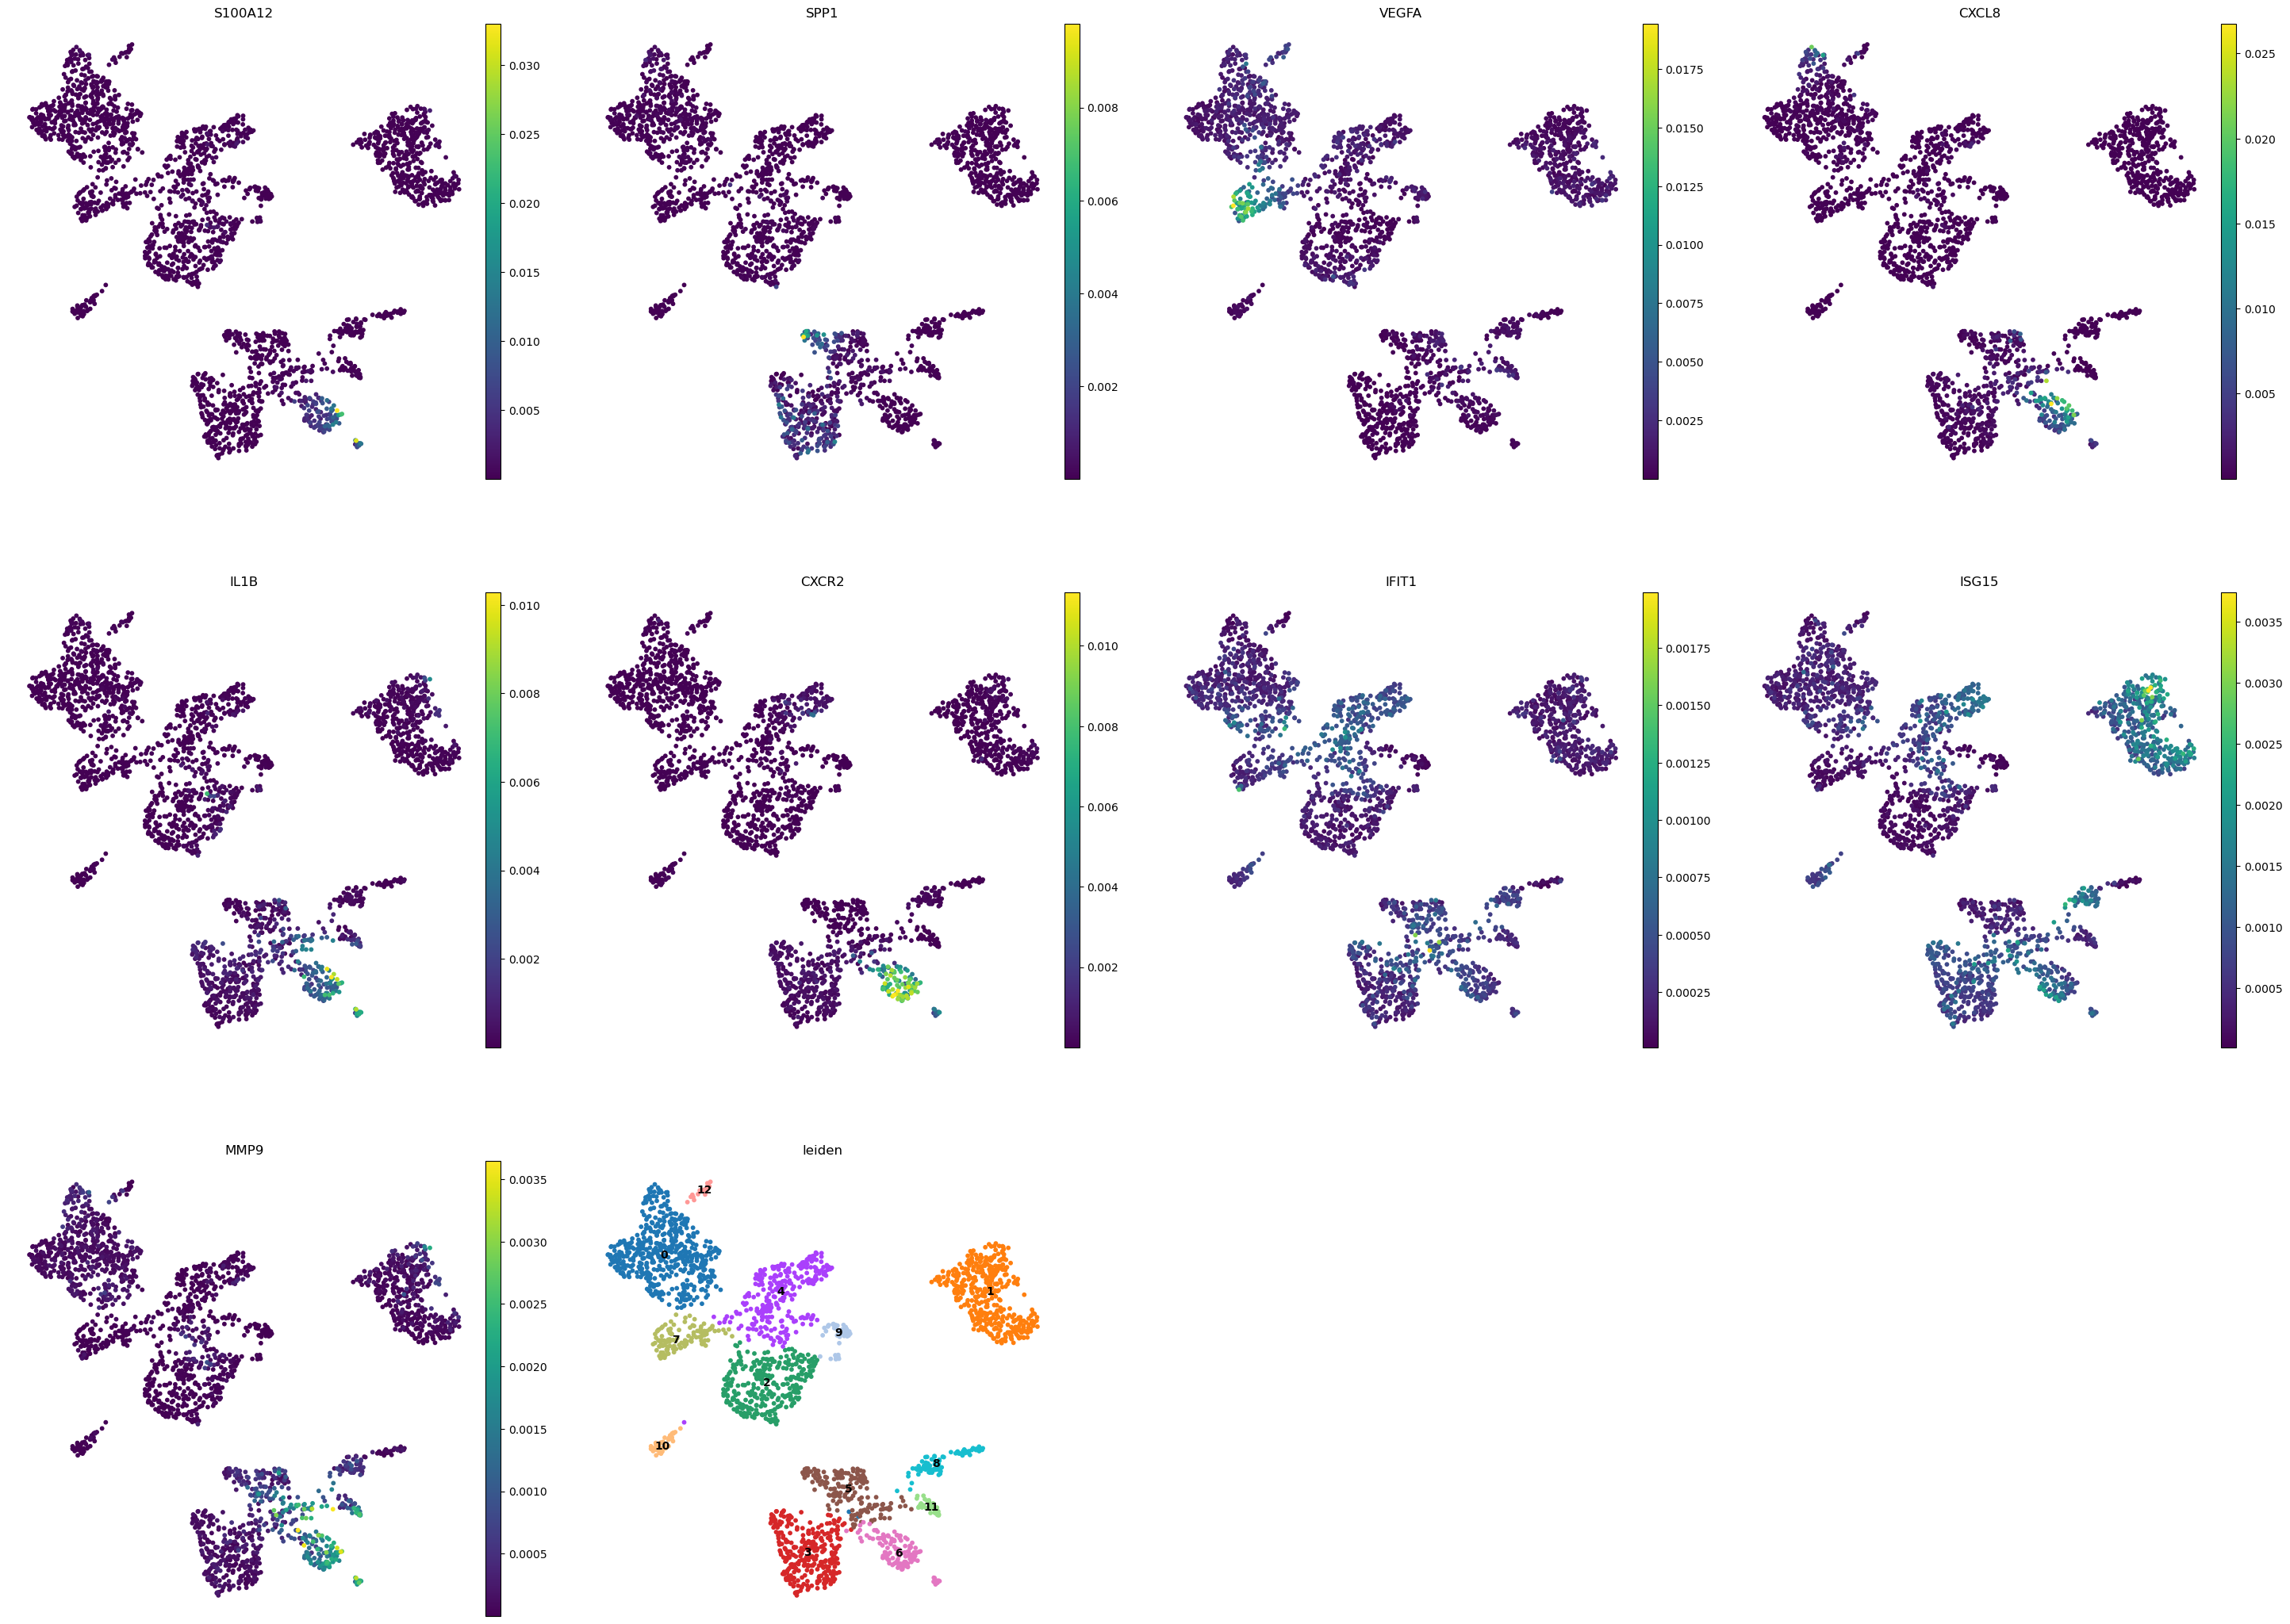

In [38]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_2, color = n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1, layer = "X_normalized_scVI")

In [70]:
scvi_df_2 = vae.differential_expression(groupby = 'leiden')

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.04s/it]


In [71]:
#scvi_df_2.to_csv('scvi_de_2_results.csv', index=False)

In [72]:
scvi_markers_2 = {}
for c in scvi_adata_2.obs.leiden.cat.categories:
    cell_df = scvi_df_2.loc[scvi_df_2.group1 == c]
    scvi_markers_2[c] = cell_df.index.tolist()[:5]

In [73]:
scvi_markers_2

{'0': ['AHCYL2', 'RAP1GAP', 'CDKL2', 'ROS1', 'SDR16C5'],
 '1': ['TRAC', 'NELL2', 'PRF1', 'GZMA', 'CD2'],
 '2': ['PDGFRA', 'MOXD1', 'TMEM119', 'COL3A1', 'COL14A1'],
 '3': ['GPD1', 'INHBA', 'FAM89A', 'ANGPT4', 'TNNT1'],
 '4': ['PLVAP', 'SSTR1', 'CLEC14A', 'VWF', 'CALCRL'],
 '5': ['LILRB5', 'FPR3', 'DEPRECATED_ENSG00000072694', 'CSF1R', 'MS4A6A'],
 '6': ['FPR1', 'APOBEC3A', 'FCAR', 'S100A8', 'PROK2'],
 '7': ['SCEL', 'NCKAP5', 'KHDRBS2', 'SLC1A1', 'ANXA3'],
 '8': ['PAX5', 'SPIB', 'IGHM', 'JCHAIN', 'IGHA1'],
 '9': ['ATP1A2', 'COL5A3', 'ITIH3', 'LDB3', 'SPEG'],
 '10': ['TM4SF18', 'STAB2', 'CCL21', 'MMRN1', 'TBX1'],
 '11': ['SLC18A2', 'SIGLEC6', 'TPSAB1', 'CTSG', 'RHEX'],
 '12': ['ALOX15', 'C1orf194', 'FAM216B', 'FAM183A', 'TSPAN1']}

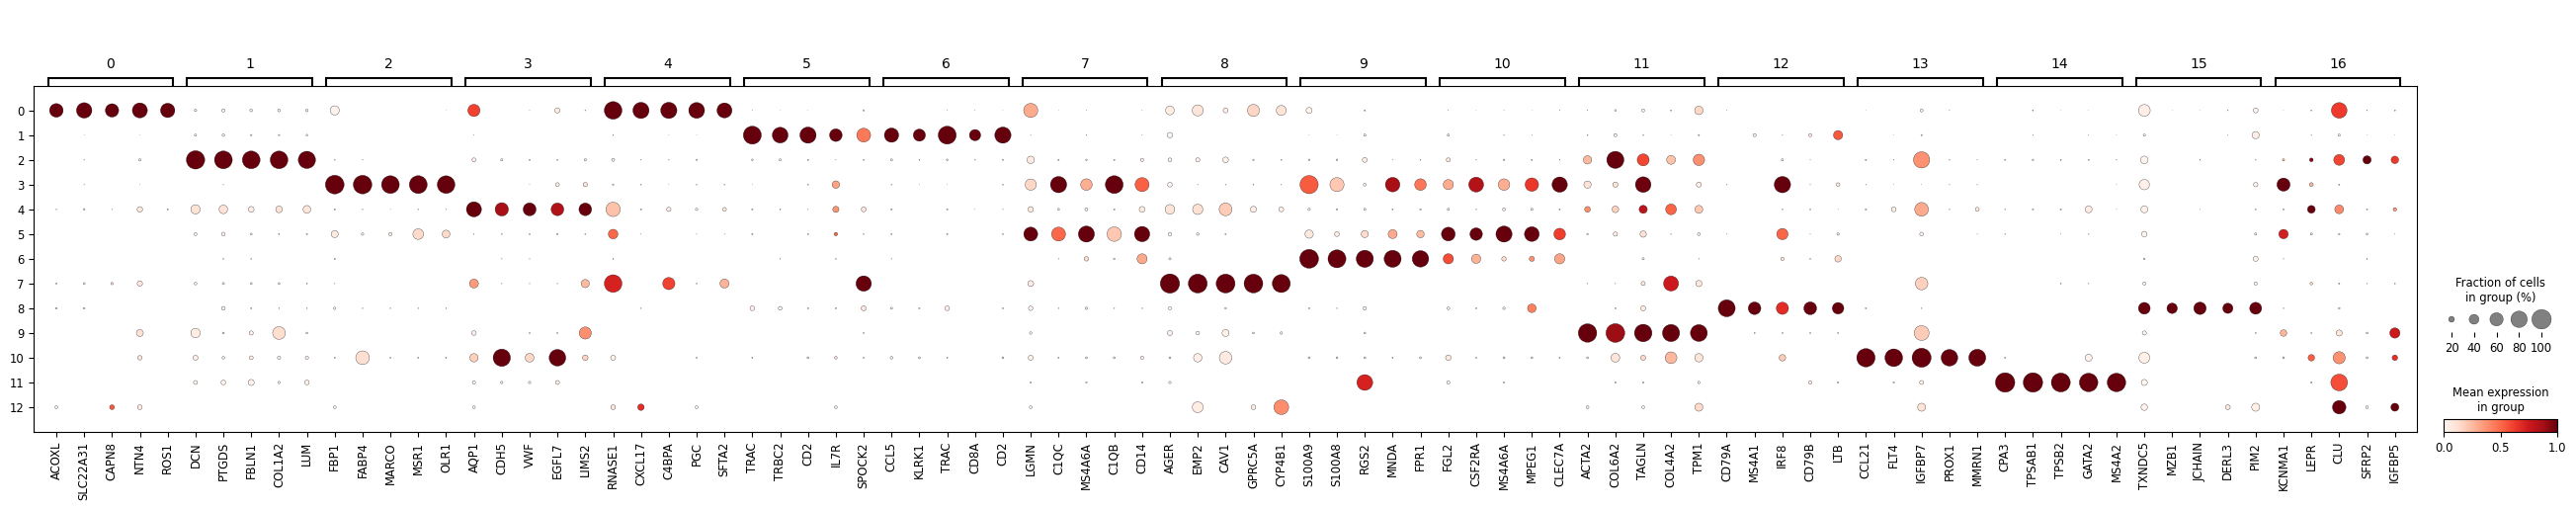

In [74]:
sc.pl.dotplot(scvi_adata_2, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [87]:
subset_scvi_adata_2 = scvi_adata_2[adata_2.obs['leiden'].isin(['6','5','3','1']), :]

In [88]:
subset_scvi_adata_2

View of AnnData object with n_obs × n_vars = 927 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'distances', 'connectivities'

In [89]:
sc.pp.neighbors(subset_scvi_adata_2, use_rep="X_scVI")
sc.tl.umap(subset_scvi_adata_2)
sc.tl.leiden(subset_scvi_adata_2, resolution = 0.5)

In [79]:
#sc.write('subset_scvi_adata_2.h5ad', subset_scvi_adata_2)

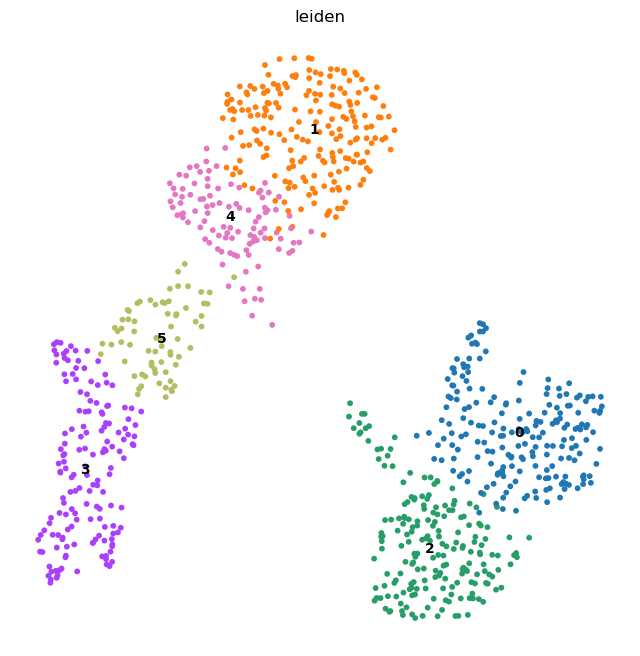

In [90]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_2, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

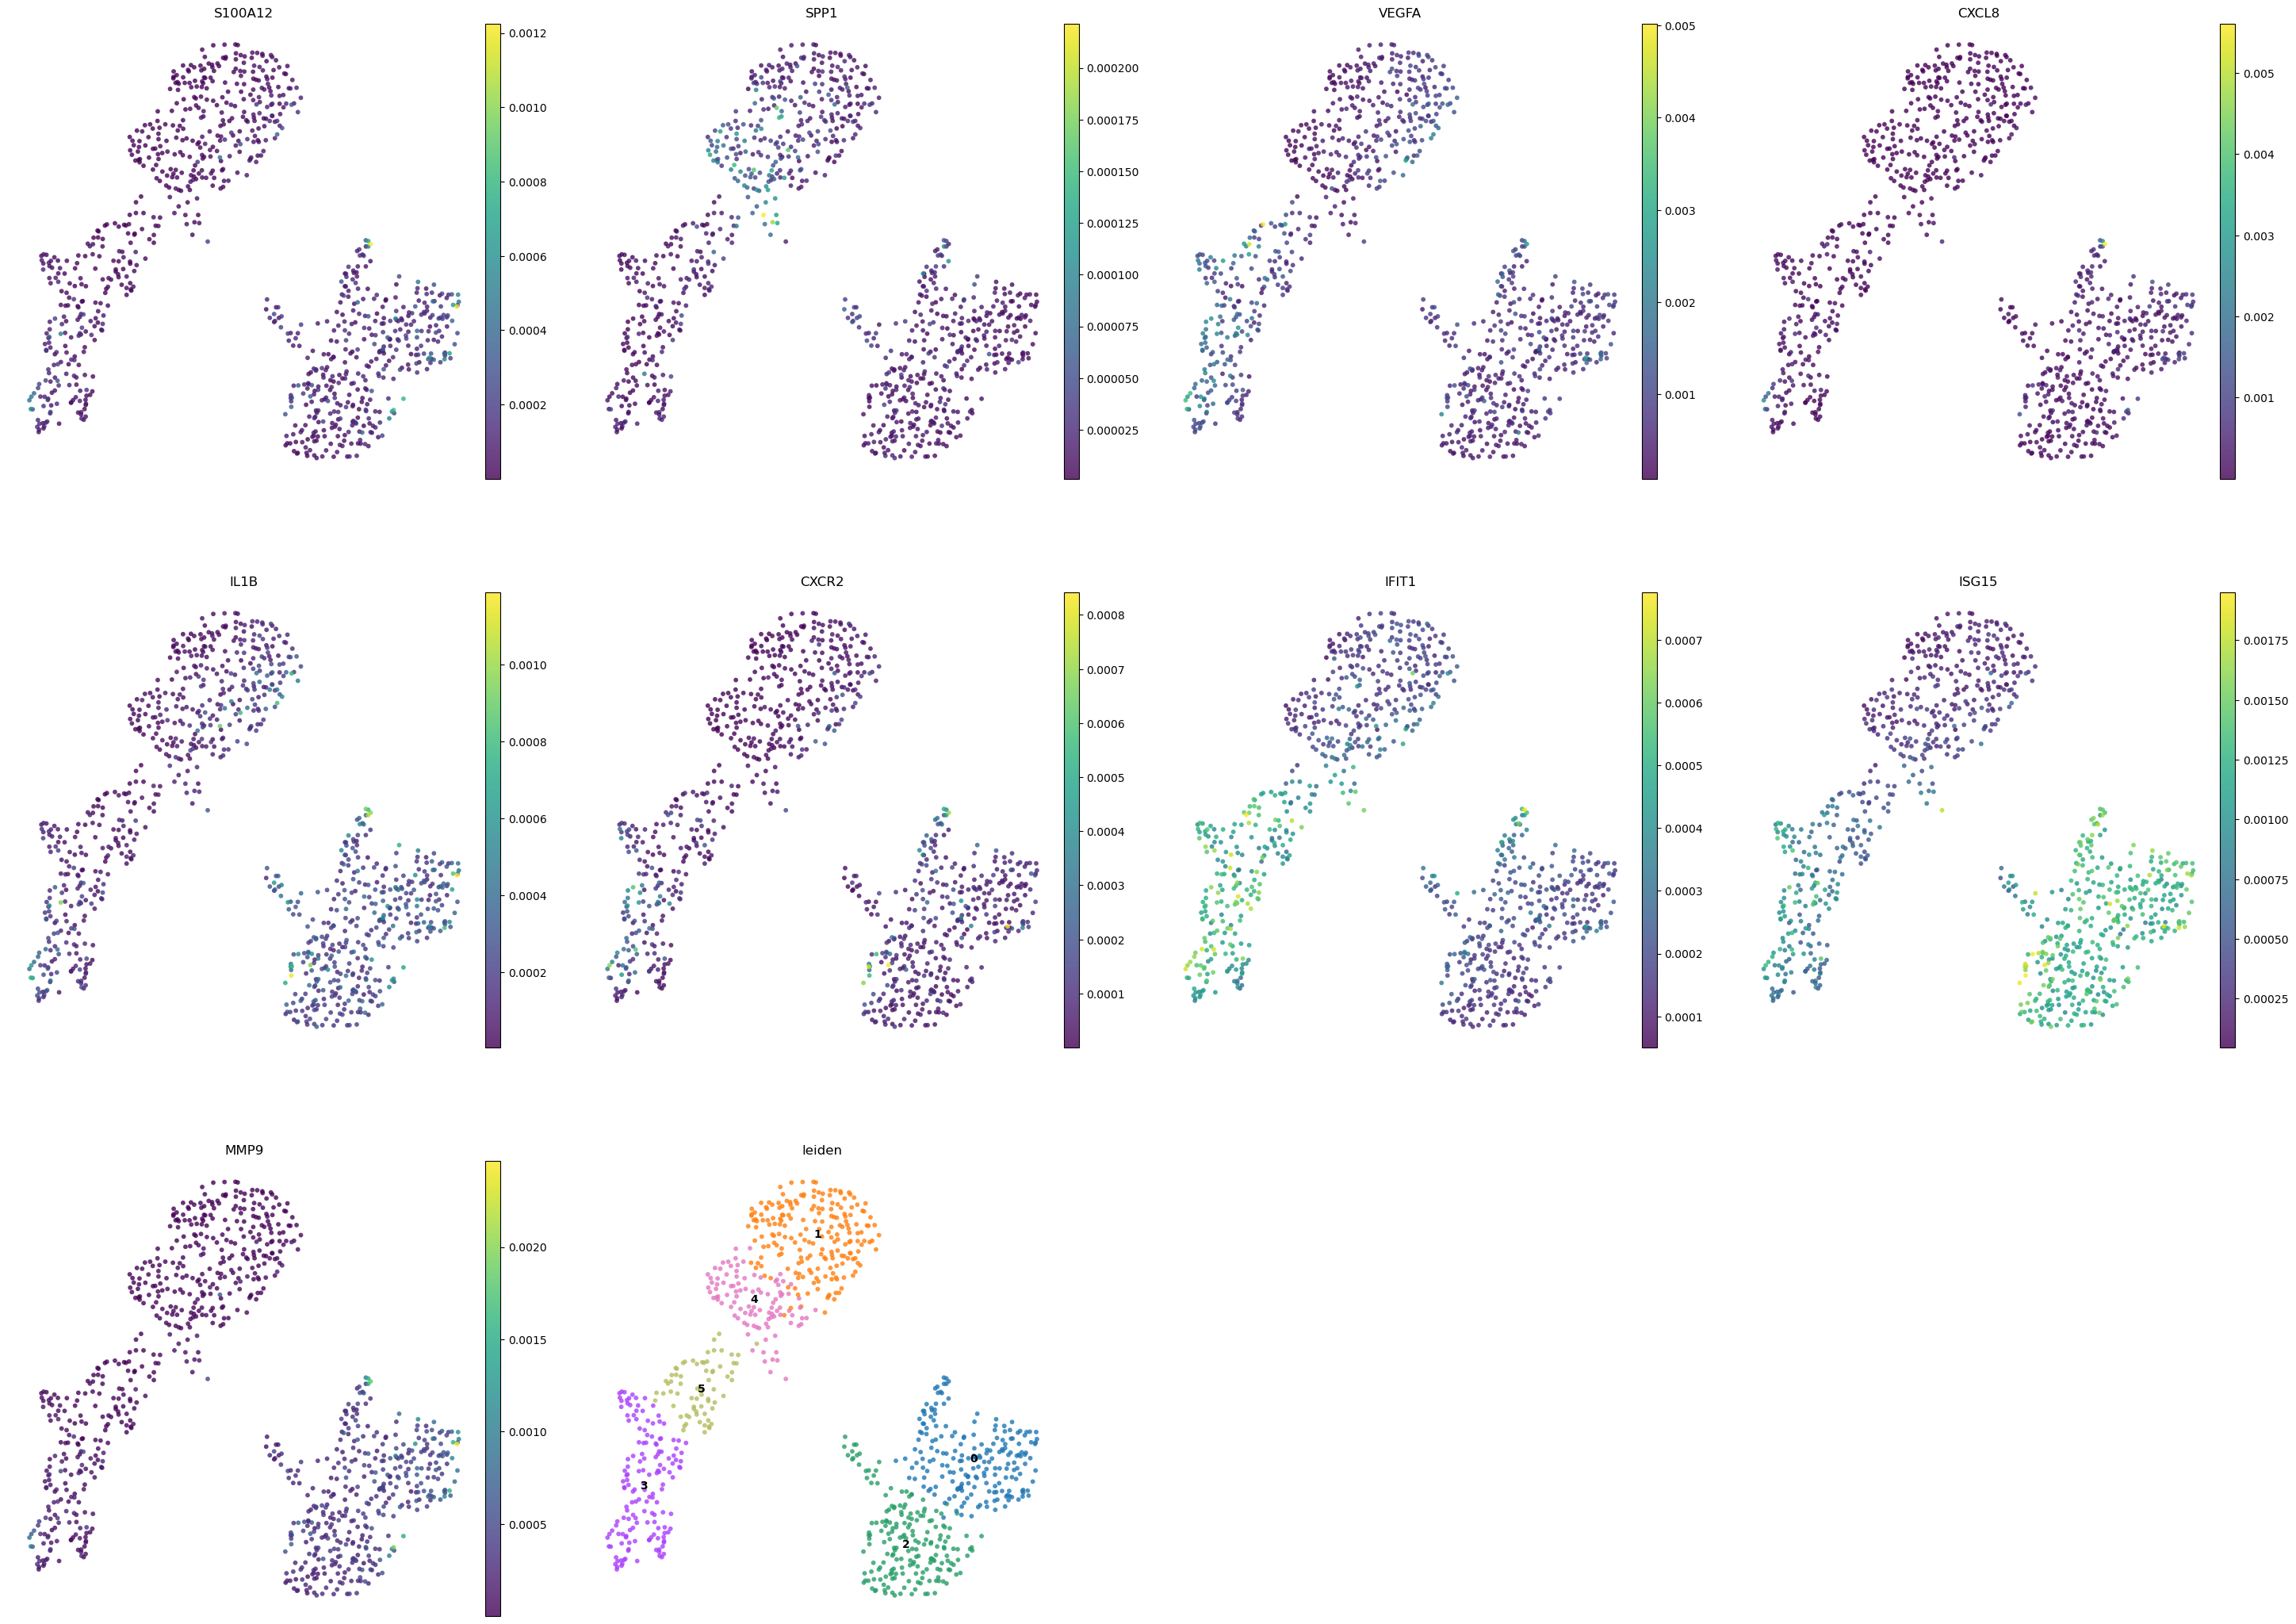

In [91]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_2, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.8, layer = "X_normalized_scVI")